# Importing Libraries

In [ ]:
!pip install elephas==0.4.5

In [ ]:
!pip install -U PyYAML

  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1


In [ ]:
import pandas as pd
import numpy as np

from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

from elephas.ml_model import ElephasEstimator
from elephas.ml.adapter import to_data_frame

from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml import Pipeline

Using TensorFlow backend.


WARNING


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt update
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/rep

# Import Dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/dr16_train.csv")
data.head()

,objid,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroR50_r,petroR90_r,petroR50_z,petroR90_z,r,i,z,redshift,zerr,mmug,mmgr,mmri,mmiz,mfug,mfgr,mfri,mfiz
0,1.237680e+18,21.63269,21.27911,21.22550,20.95690,20.82752,22.05036,21.62439,21.64663,21.32027,21.40336,0.562805,1.068754,0.166565,0.238479,21.22550,20.95690,20.82752,1.839604,0.001146,21.455900,21.252305,21.091200,20.89221,21.837375,21.635510,21.48345,21.361815
1,1.237680e+18,19.74829,19.45819,19.33118,19.01371,18.80369,20.10190,19.79539,19.66580,19.35386,19.15471,0.631004,1.339584,0.602479,1.350725,19.33118,19.01371,18.80369,2.069321,0.000354,19.603240,19.394685,19.172445,18.90870,19.948645,19.730595,19.50983,19.254285
2,1.237680e+18,23.74654,23.19651,22.01303,20.80744,19.91660,24.60136,23.64122,22.48040,21.31004,20.34262,0.645596,1.295767,0.923503,2.043880,22.01303,20.80744,19.91660,0.814588,0.000212,23.471525,22.604770,21.410235,20.36202,24.121290,23.060810,21.89522,20.826330
3,1.237680e+18,20.63075,20.25426,20.04478,19.79378,19.70326,20.99431,20.60174,20.40031,20.19795,19.95800,0.657796,1.482055,0.764345,1.480650,20.04478,19.79378,19.70326,1.455912,0.000394,20.442505,20.149520,19.919280,19.74852,20.798025,20.501025,20.29913,20.077975
4,1.237680e+18,21.38126,21.13488,21.09993,20.92882,20.80634,21.85225,21.45860,21.45340,21.19782,20.63075,0.728897,2.212801,1.027675,1.458456,21.09993,20.92882,20.80634,1.651130,0.000760,21.258070,21.117405,21.014375,20.86758,21.655425,21.456000,21.32561,20.914285


In [ ]:
data[data["modelMag_u"]==-9999]=np.nan
data[data["modelMag_g"]==-9999]=np.nan
data[data["modelMag_r"]==-9999]=np.nan
data[data["modelMag_i"]==-9999]=np.nan
data[data["modelMag_z"]==-9999]=np.nan
data[data["fiberMag_u"]==-9999]=np.nan
data[data["fiberMag_g"]==-9999]=np.nan
data[data["fiberMag_r"]==-9999]=np.nan
data[data["fiberMag_i"]==-9999]=np.nan
data[data["fiberMag_z"]==-9999]=np.nan
data[data["petroR50_r"]==-9999]=np.nan
data[data["petroR90_r"]==-9999]=np.nan
data[data["petroR50_z"]==-9999]=np.nan
data[data["petroR90_z"]==-9999]=np.nan
data[data["r"]==-9999]=np.nan
data[data["i"]==-9999]=np.nan
data[data["z"]==-9999]=np.nan
data[data["redshift"]<0]=np.nan

In [ ]:
print(data.shape)
data=data.dropna()
print(data.shape)
data1=data.to_numpy()

(3651936, 28)
(3548153, 28)


In [ ]:
df = pd.DataFrame(data)

In [ ]:
X=df.iloc[:50000,1:18]
y=df.iloc[:50000,18]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.30, random_state=0)

# Data Preprocessing

### Correlation Matrix
There are certain features which are highly correlated that means which are some what linearly dependent with other features. These features contribute very less predicting the output but increses the computational cost.

1. Calculates correlation between different features.
2. Drops highly correlated features to escape curse of dimensionality.

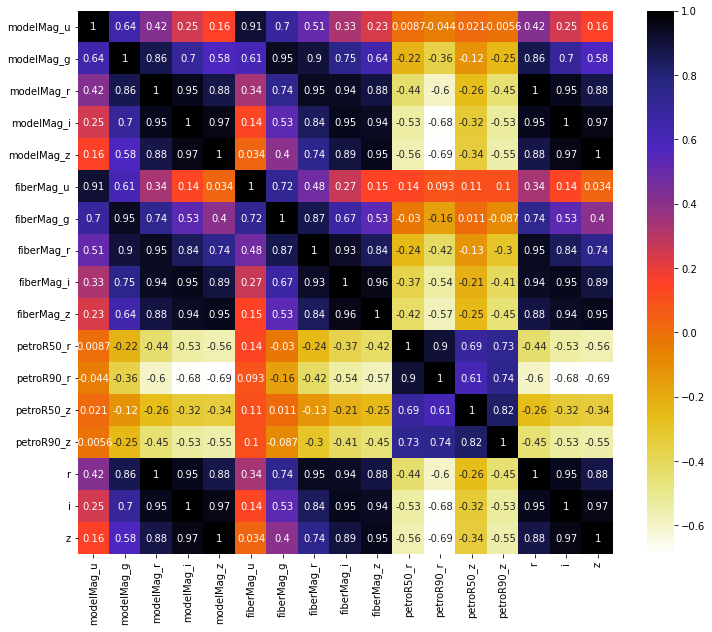

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,10))
cor = x_train.corr()
sns.heatmap(cor, annot = True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
upper_tri = cor.where(np.triu(np.ones(cor.shape),k=1).astype(np.bool))
print(upper_tri)

            modelMag_u  modelMag_g  modelMag_r  ...         r         i         z
modelMag_u         NaN    0.643905    0.421752  ...  0.421752  0.250891  0.160922
modelMag_g         NaN         NaN    0.863732  ...  0.863732  0.697468  0.581785
modelMag_r         NaN         NaN         NaN  ...  1.000000  0.947728  0.875955
modelMag_i         NaN         NaN         NaN  ...  0.947728  1.000000  0.966840
modelMag_z         NaN         NaN         NaN  ...  0.875955  0.966840  1.000000
fiberMag_u         NaN         NaN         NaN  ...  0.335116  0.137125  0.033596
fiberMag_g         NaN         NaN         NaN  ...  0.738739  0.531193  0.400464
fiberMag_r         NaN         NaN         NaN  ...  0.946505  0.841855  0.744922
fiberMag_i         NaN         NaN         NaN  ...  0.938923  0.948918  0.891623
fiberMag_z         NaN         NaN         NaN  ...  0.884223  0.939966  0.947213
petroR50_r         NaN         NaN         NaN  ... -0.435674 -0.533474 -0.558603
petroR90_r      

In [ ]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(); print(to_drop)


['modelMag_i', 'modelMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z', 'petroR90_r', 'r', 'i', 'z']


In [ ]:
X=data.iloc[:50000, [1, 2, 3, 11, 13, 14]].values
#X=data1[:,1:19]
y=data.iloc[:50000,18].values

#### Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#### Standardization 

In [ ]:
from sklearn.preprocessing import StandardScaler
# define min max scaler
scaler = StandardScaler()
# transform data
X = scaler.fit_transform(X)

In [ ]:
# Define basic parameters
batch_size = 64
epochs = 25

In [ ]:
!pip install PyYAML==5.4.1

  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [ ]:
# Create Spark context
conf = SparkConf().setAppName('Cascade_Spark_MLP').setMaster('local[*]')
sc = SparkContext(conf=conf)

### K_Fold Cross Validation and Cascading

In [ ]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits=5, random_state=None)
for train_index, test_index in kf.split(X):
      print("Train:", train_index, "Validation:",test_index)
      X_train, X_test = X[train_index], X[test_index] 
      y_train, y_test = y[train_index], y[test_index]

      X_train = X_train.astype("float32")
      X_test = X_test.astype("float32")
      X_train /= 255
      X_test /= 255

      acc_score = []
      model = Sequential()
      model.add(Dense(64, input_shape=(X_train.shape[1],)))
      model.add(Activation('relu'))
      model.add(Dense(128))
      model.add(Activation('relu'))
      model.add(Activation('relu'))
      model.add(Dense(256))
      model.add(Activation('relu'))
      model.add(Dense(1))
      model.add(Activation('linear'))

      

      #Build RDD from numpy features and labels
      df = to_data_frame(sc, X_train, y_train)
      test_df = to_data_frame(sc, X, y)

      # sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
      # sgd_conf = optimizers.serialize(sgd)
      opt = optimizers.Adam(lr=0.01)
      sgd_conf = optimizers.serialize(opt)
      # Initialize Spark ML Estimator
      estimator = ElephasEstimator()
      estimator.set_keras_model_config(model.to_yaml())
      estimator.set_optimizer_config(sgd_conf)
      estimator.set_mode("synchronous")
      estimator.set_loss("mae")
      estimator.set_metrics(['mse'])
      estimator.set_epochs(epochs)
      estimator.set_batch_size(batch_size)
      estimator.set_validation_split(0.1)
      estimator.set_categorical_labels(False)


      # Fitting a model returns a Transformer
      pipeline = Pipeline(stages=[estimator])
      fitted_pipeline = pipeline.fit(df)

      # Evaluate Spark model by evaluating the underlying model
      prediction = fitted_pipeline.transform(test_df)
      pnl = prediction.select("label", "prediction")
      #pnl.show(10)

      prediction_and_label = pnl.rdd.map(lambda row: (row.label, row.prediction))
      metrics = RegressionMetrics(prediction_and_label)
      print(metrics.r2)
      print("Cascading")

      #Cascading
      X_new = np.zeros((50000,7))
      X_new[:,:-1] = X
      X_new[:, -1] = np.array(pnl.select('prediction').collect())[:,0]

      from sklearn.model_selection import KFold 
      kf = KFold(n_splits=5, random_state=None)
      for train_index, test_index in kf.split(X_new):
            print("Train:", train_index, "Validation:",test_index)
            X_train, X_test = X[train_index], X[test_index] 
            y_train, y_test = y[train_index], y[test_index]

            X_train = X_train.astype("float32")
            X_test = X_test.astype("float32")
            X_train /= 255
            X_test /= 255

            acc_score = []
            model = Sequential()
            model.add(Dense(64, input_shape=(X_train.shape[1],)))
            model.add(Activation('relu'))
            model.add(Dense(128))
            model.add(Activation('relu'))
            model.add(Activation('relu'))
            model.add(Dense(256))
            model.add(Activation('relu'))
            model.add(Dense(1))
            model.add(Activation('linear'))

      

            #Build RDD from numpy features and labels
            df = to_data_frame(sc, X_train, y_train)
            test_df = to_data_frame(sc, X, y)

            # sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            # sgd_conf = optimizers.serialize(sgd)
            opt = optimizers.Adam(lr=0.01)
            sgd_conf = optimizers.serialize(opt)
            # Initialize Spark ML Estimator
            estimator = ElephasEstimator()
            estimator.set_keras_model_config(model.to_yaml())
            estimator.set_optimizer_config(sgd_conf)
            estimator.set_mode("synchronous")
            estimator.set_loss("mae")
            estimator.set_metrics(['mse'])
            estimator.set_epochs(epochs)
            estimator.set_batch_size(batch_size)
            estimator.set_validation_split(0.1)
            estimator.set_categorical_labels(False)


            # Fitting a model returns a Transformer
            pipeline = Pipeline(stages=[estimator])
            fitted_pipeline = pipeline.fit(df)

            # Evaluate Spark model by evaluating the underlying model
            prediction = fitted_pipeline.transform(test_df)
            pnl = prediction.select("label", "prediction")
            #pnl.show(10)

            prediction_and_label = pnl.rdd.map(lambda row: (row.label, row.prediction))
            metrics = RegressionMetrics(prediction_and_label)
            print(metrics.r2)
            
            #print(metrics.meanAbsoluteError)
            #print(metrics.rootMeanSquaredError) 
            
      #print(metrics.meanAbsoluteError)
      #print(metrics.rootMeanSquaredError)    

Train: [10000 10001 10002 ... 49997 49998 49999] Validation: [   0    1    2 ... 9997 9998 9999]










>>> Fit model
>>> Synchronous training complete.
-0.4342022093668563
Cascading
Train: [10000 10001 10002 ... 49997 49998 49999] Validation: [   0    1    2 ... 9997 9998 9999]
>>> Fit model
>>> Synchronous training complete.
-0.7140833201359096
Train: [    0     1     2 ... 49997 49998 49999] Validation: [10000 10001 10002 ... 19997 19998 19999]
>>> Fit model
>>> Synchronous training complete.
-0.42997251075156107
Train: [    0     1     2 ... 49997 49998 49999] Validation: [20000 20001 20002 ... 29997 29998 29999]
>>> Fit model
>>> Synchronous training complete.
-0.5619080775474563
Train: [    0     1     2 ... 49997 49998 49999] Validation: [30000 30001 30002 ... 39997 39998 39999]
>>> Fit model
>>> Synchronous training complete.
-0.4915789978726195
Train: [    0     1     2 ... 39997 39998 39999] Validation: [40000 40001 40002 ... 49997 49998 49999]
>>> Fit model
>>> Synchronou

# Results

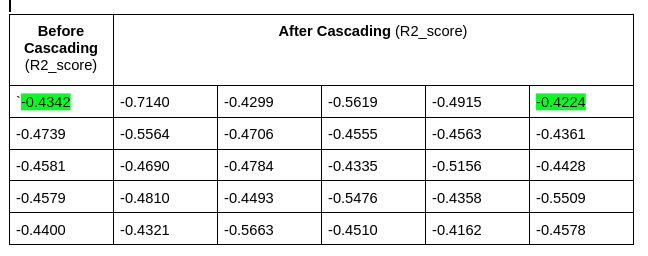

## Conclusion

The best result came out to be:

**Before Cascading** 
-0.4342

**After Cascading** -0.4224